In [1]:
import os
os.getpid()

32592

# Feature Extraction
Here we extract the words that have more impact on another

In [2]:
import random
list2 = []
file_data = open('amazon_review_less_than_300_chars_balanced.csv')
for row in file_data:
    list2.append(row)## Data pre-processing module
    
list3 = []
for i in range(len(list2)):
    list3.append((list2[i][-2],list2[i][:-3]))
    
random.seed(10)
random.shuffle(list3)

lenth = len(list3)
train_list = list3[0:int(lenth*0.8)]
test_list = list3[int(lenth*0.8):]
print(len(test_list), len(train_list))
print(train_list[3000])

l = []
for i,j in list3:
    if i not in l:
        l.append(i)
print(l)
di = {}
test_list[0][0]
for i in test_list:
    if i[0] not in di.keys():
        di.update({i[0]:0})
    else:
        di[i[0]] += 1
print(di)

100000 400000
('4', '"i will recommend this product to my friends. it gives energy to my skin, my face seems younger and feels fresh"')
['3', '5', '1', '2', '4']
{'2': 19877, '3': 19910, '4': 20176, '1': 19963, '5': 20069}


In [3]:
list4 = []
for i in list3:
    list4.extend(i[1].split(" "))
print(list4[0])

from collections import Counter
import re

c = Counter(list4)

"not


In [4]:
# NB: In this version,
# WE ONLY embed for frequent words.
# Other words are all converterted to "N0O0N"
selected = c.most_common(20000)
selected_index_word = []
for i in selected:
    selected_index_word.append(i[0])
selected_index_word[-1]

'mot'

## We are only considering the 20000 most common words
## We convert all other words to N0O0N, which indicate unknown words.

In [5]:
# convert to N0O0N
def convert(word_list):
    for i, v in enumerate(word_list):
        if v not in selected_index_word:
            word_list[i] = "N0O0N"
    return word_list

In [6]:

import numpy as np

import torch
from torch.utils.data.sampler import BatchSampler, Sampler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import random
from tqdm import tqdm

SEED=4321
random.seed(SEED)
np.random.seed(SEED)


class Corpora():
    """
    The class holds training and test corpora.
    """

    def __init__(self):
        """
        Constructor
        """
        # word to index (1-based integers) mapping
        self.word_index = {"N0O0N":0}
        self.index_word = ["N0O0N"]
        # list of reviews tuples, each of which is (sentence_list, rate),
        self.training_reviews = []
        # (sentence_list, rate) Same format as training_sentences
        self.test_reviews = []

        self.max_len = 0


    # input: a tuple (reviewList, rate)
    # todo: insert values into fields
    # Return the list representing all index of words in a review.
    def insert_fields(self, input):   
        # Sentence list
        word_indexes = []
        for word in input:
            if word not in self.word_index.keys():
                self.word_index.update({word:len(self.word_index.keys())}) #No add 1 because 0 is already in
                self.index_word.append(word)
            # find the index of this word, add to return list
            word_indexes.append(self.word_index[word])
        if len(word_indexes)>self.max_len:
            self.max_len = len(word_indexes)
        return word_indexes
    
    
    
    
    # Different than P2, here we 
    def read_corpus(self, is_training):
        if is_training is True:
            target = train_list
        else:
            target = test_list
        print("reading corpus ...")
        for rate, text in tqdm(target):
            input = text.split(" ")
            input = convert(input)
            tuple = (self.insert_fields(input), rate)
            if is_training: 
                self.training_reviews.append(tuple)
            else:
                self.test_reviews.append(tuple)
                    
                
# Inherient Dataset, convert list and int to tensors, load to GPU.
class ReviewRateDataset(Dataset):
   
    def __init__(self, review_rate_pairs): # NB: sequence_pairs is corpora.training_reviews, 
        # list of (sentence_list, rate)
        self.review_rate_pairs = review_rate_pairs

    def __len__(self):
        return len(self.review_rate_pairs)

    def __getitem__(self, idx):
        sentence_list, rate = self.review_rate_pairs[idx] 
        return torch.tensor(sentence_list), torch.tensor(int(rate))

# NB! This class will be in DataLoader function as a parameter for batch_sampler
class SortedBatchSampler(Sampler):
    """
        Each sequence in a mini-batch must of the same lengths, while our sentences
        are of various lengths.
        We can pad the sentences to the same lengths in each mini-batch.
        But if a short and long sentences are in the same mini-batch, more paddings
        are needed.
        We sort the sentences based on their lengths (in descending order)
            and then put sentences with similar lengths in a batch to reduce the paddings.
    """
    def __init__(self, dataset, batch_size):
        """
            dataset: an torch.utils.data.DataSet object containing all training sequences
            batch_size: the number of sequences to put in a mini-batch
        """

        # The sorting and batching go within this function.      
        self.batch_size = batch_size 
        # Sort the dataset (Based on the length of sentence.)
        dataset.review_rate_pairs  = sorted(dataset.review_rate_pairs,key=lambda x:len(x[0]), reverse=True)
        self.sorted_lengths = len(dataset)
        # Batching: Split the dataset into a list of datasets
        self.index_batches = []  
        # -- NB: Collate function does not work, so I pad it directly.
        for i in range(self.__len__()):
            self.index_batches.append(padding_collate_func(ReviewRateDataset(dataset.review_rate_pairs[i*batch_size:i*batch_size+batch_size])))
        # Now, each mini-batches is a ReviewRateDataset object
        # If else format is needed, may change it latter.
        
        
    def __iter__(self):
        """
            return a Python iterator object that iterates the mini-batchs of
                training data indices (not individual indices)
        """
        return iter(self.index_batches)

    def __len__(self):
        return self.sorted_lengths // self.batch_size

# NB! This function will be in DataLoader function as a parameter for collate_fn
def padding_collate_func(batch):
    """
        Transform pairs of input-output sequences in the batch to be of the same length using the function
            torch.nn.utils.rnn.pad_sequence.
        batch: An iterator and each element is a pair of (input_sequence, output_sequence).
        For POS tagging, len(input_sequence) = len(output_sequence). But for different
        pairs in batch, their lengths can differ.

        Example: a batch of 3 pairs of input/output sequences
                [([1,2,3],[1,1,1]), ([1,2,3,4],[2,2,2,2]), ([1,2,3,4,5],[3,3,3,3,3])]
                Note: [] encloses tensors (not numpy arra ys)
                
                
                !!!!!NB QUESTION:  it is the inner [] that encloses tensors, right?
                Comment: Batch is an element of a Sampler (see test_p1.py, a l[0] is a batch)
                
                
        return: two tensors (one for input sequence batch and another for output sequence batch).
                These tensors are padded with zeros so that all sequences in the same batch
                are of the same length.
        Example: input_sequence_batch = [[1,2,3,0,0], [1,2,3,4,0], [1,2,3,4,5]],
                 output_sequence_batch = [[1,1,1,0,0], [2,2,2,2,0], [3,3,3,3,3]]

    """
    ### Your codes go here (5 points) ###
    # Hint: read the article linked at the top of this cell.
    
    # NOTe
    # len(batch[0][0]) == len(batch.sequence_pairs[0]) == the target value (the maximum length for each batch)
    # I fill it might be easier to pad sequence_pairs with tuple (0,0), but let's see.
    
    # Doubles the memory takes by this batch, which is not good
    new_l = []
    rate = []
    for i,j in batch.review_rate_pairs:
        new_l.append( torch.tensor(i))
        rate.append( torch.tensor(int(j)))
    padded = pad_sequence(new_l, batch_first=True, padding_value=0)
    #print("len ", len(padded), len(rate)) #BUG: NEED ZIP HERE
    obj = ReviewRateDataset(list(zip(padded,rate)))
    # NB: For now the outter [] is neither tensor nor list, it is an obj!
    # Change latter if necessary
    # Yes, let's change it to two tensors return
    ret1 = []
    ret2 = []
    for i in obj:
        ret1.append(i[0])
        ret2.append(i[1])
    ret1 = torch.stack(ret1)
    ret2 = torch.stack(ret2)
    return ret1, ret2

# Load Corpora, Get DataLoader Ready

In [7]:
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL

#
#
from torch import optim
import time
import math

BATCH_SIZE = 64


corpora = Corpora()

corpora.read_corpus(True)
corpora.read_corpus(False)

print(f'Number of training sentences = {len(corpora.training_reviews)}')
print(f'Number of test sentences = {len(corpora.test_reviews)}')
print(f'Number of unique input tokens = {len(corpora.word_index)}')
print(f'Maximal sentence length = {corpora.max_len}')

print("\n\n Creating training Dataset, Sampler, and Iterators...")
training_dataset = ReviewRateDataset(corpora.training_reviews)
training_sampler = SortedBatchSampler(training_dataset, batch_size=BATCH_SIZE)
training_iterator = DataLoader(training_dataset,
                                  collate_fn = padding_collate_func,
                                  batch_sampler = training_sampler)
print("\n\n Creating test Dataset, Sampler, and Iterators")
test_dataset = ReviewRateDataset(corpora.test_reviews)
test_sampler = SortedBatchSampler(test_dataset, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_dataset,
                              collate_fn = padding_collate_func,
                              batch_sampler = test_sampler)

print(f'Training first batch max length = {len(list(training_sampler)[0][0][0])}')
print(f'Training second batch max length = {len(list(training_sampler)[1][0][0])}')
print(f'Training last batch max length = {len(list(training_sampler)[-1][0][0])}')
print(f'Training second last batch max length = {len(list(training_sampler)[-2][0][0])}')






reading corpus ...


100%|██████████| 400000/400000 [05:55<00:00, 1126.24it/s]


reading corpus ...


100%|██████████| 100000/100000 [01:28<00:00, 1126.13it/s]
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of training sentences = 400000
Number of test sentences = 100000
Number of unique input tokens = 20001
Maximal sentence length = 226


 Creating training Dataset, Sampler, and Iterators...


 Creating test Dataset, Sampler, and Iterators
Training first batch max length = 226
Training second batch max length = 68
Training last batch max length = 10
Training second last batch max length = 12


# Extractor
# Here, one hot embedding is used
## A score for each words is a trainable vector. Higher means positive word, lower means negative word.

In [259]:

from torch import embedding, nn
# There is really nothing to be stored in this object.
# -- But wait, how about self.rnn and self.fc?
# -- NB: NOW, I assume that the nn keep weights from the inherentance,
# -- And these functions as LSTM and FC will use these weight correctly
class FeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        """
        :param input_dim: size of the vocabulary (number of unique tokens)
        :param output_dim: number of unique POS tags 
        :param emb_dim: embedding dimensionality of each token
        :param hid_dim: number of hidden neurons of a hidden state/cell
        :param n_layers: number of RNN layers (2 for faster training)
        :param dropout: dropout rate between 0 and 1at the embedding layer and rnn
        :param bidirectional: 1 if use bidirectional and 0 if don't
        """
        super().__init__()



        self.embedding = nn.functional.one_hot(torch.arange(input_dim).cuda(3))
        
        # The Initialization below does not work. Initial in the next cell's next cell!
        vector_weights = [30000.0]*input_dim
        self.vector_weights = nn.Parameter(torch.tensor(vector_weights, requires_grad=True).cuda(3))

        

        # self.dropout = nn.Dropout(dropout)


    def forward(self, src):
        """

        :param src: a [batch_size, sentence_len] array.
                     Each row is a sequence of word indices and each column represents a position in the sequence.
        :return: the predicted logits at each position. 
        """

        emb = torch.sum(self.embedding[src],dim=2)
        emb = torch.tensor(emb, dtype=torch.float)
        w = self.vector_weights[src]
        # A Vector of Batch_size * 1
        z = torch.sum(w*emb,dim=1)


        return z



# The Weights Initialization Goes Here.

In [318]:
INPUT_DIM = len(corpora.word_index)

# initialize the model
featureExtractor = FeatureExtractor(INPUT_DIM).cuda(3)

# Glove Embedding here?
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

featureExtractor.apply(init_weights)

optimizer = optim.Adam(featureExtractor.parameters())


tmp = optimizer.state_dict()
tmp["param_groups"][0]["lr"] = 0.0005
optimizer.load_state_dict(tmp)
print(optimizer)

# we use 0 to represent padded POS tags and the loss function should ignore that.
# we calculate the sum of losses of pairs in each batch
PAD_INDEX = 0


# input: vector of [length, output_dim], integer (score)

N_EPOCHS = 10
CLIP = 1

best_test_loss = float('inf')

training_losses = []
test_losses = []

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)


In [319]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -- The Iterator is a Dataloader object. 
# -- Use for loop in iterator.batch_sampler to access each batches
# -- In this case, each batches is having length 128

# -- Need to Figure out: The way to compute loss for RNN
num_epochs_train = 0

def train(model, iterator, optimizer,  clip, num_epochs=0):
    
    global num_epochs_train
    if num_epochs_train == 2:
        tmp = optimizer.state_dict()
        tmp["param_groups"][0]["lr"] = 0.00025
        optimizer.load_state_dict(tmp)
    if num_epochs_train == 5:
        tmp = optimizer.state_dict()
        tmp["param_groups"][0]["lr"] = 0.0001
        optimizer.load_state_dict(tmp)
    if num_epochs_train == 7:
        tmp = optimizer.state_dict()
        tmp["param_groups"][0]["lr"] = 0.00006
        optimizer.load_state_dict(tmp)

    model.train()
    epoch_loss = 0
    num_batchs = 0
    total = 0

    
    random.shuffle(iterator.batch_sampler.index_batches)
    
    # batch[0]: the word batch
    # batch[1]: the tag batch (target)
    print("training ...")
    for i, batch in tqdm(enumerate(iterator.batch_sampler)):
        
          # NB: SURPRISE! THE LINE BELOW BOOST TEST ACCURACY
        optimizer.zero_grad()

        num_batchs += 1
        z = featureExtractor.forward(batch[0].cuda(3))
        # absolution distance loss
        # About 0.8 after 1st ephoch (regression loss)
        loss= sum(abs(z - torch.tensor(batch[1]-3).cuda(3)))/BATCH_SIZE

        # loss= torch.sqrt(sum(pow(z - torch.tensor(batch[1]).cuda(3),2)))/BATCH_SIZE

        loss.backward()
        
        # Clips gradient norm of an iterable of parameters.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        total += 1
    num_epochs_train += 1

    return epoch_loss /total


num_epochs = 0

def evaluate(model, iterator):
    
    model.eval()
    epoch_loss = 0
    total = 0
    
    global num_epochs
    for i, batch in tqdm(enumerate(iterator.batch_sampler)):
        z = featureExtractor.forward(batch[0].cuda(3))       
        # absolution distance loss
        loss= sum(abs(z - (torch.tensor(batch[1]-3).cuda(3))))/BATCH_SIZE      
        epoch_loss += loss.item()
        total += 1
        
     
    num_epochs += 1
        
    return epoch_loss/total

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs




# Start Train

In [320]:
for epoch in range(N_EPOCHS):  
    print("epoch start: ", epoch)  
    start_time = time.time()
    training_loss = train(featureExtractor, training_iterator, optimizer, CLIP)
    training_losses.append(training_loss)
    test_loss = evaluate(featureExtractor, test_iterator)
    test_losses.append(test_loss)  
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if test_loss < best_test_loss:
        best_test_loss = test_loss 
        torch.save(featureExtractor.state_dict(), 'best_model.pt')
        

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', end='')
    print(f'\tTrain Loss: {training_loss:.3f} | Test Loss: {test_loss:.3f}')

import pickle
with open(f'results/losses_L.pkl', 'wb') as f:
    pickle.dump({'training_losses': training_losses,
                'test_losses': test_losses}, f)

epoch start:  0
training ...


0it [00:00, ?it/s]/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
6250it [00:25, 243.06it/s]
0it [00:00, ?it/s]/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
1562it [00:03, 397.23it/s]


Epoch: 01 | Time: 0m 29s	Train Loss: 0.856 | Test Loss: 0.800
epoch start:  1
training ...


6250it [00:25, 241.29it/s]
1562it [00:03, 398.54it/s]


Epoch: 02 | Time: 0m 29s	Train Loss: 0.783 | Test Loss: 0.790
epoch start:  2
training ...


6250it [00:25, 241.14it/s]
1562it [00:03, 397.84it/s]


Epoch: 03 | Time: 0m 29s	Train Loss: 0.768 | Test Loss: 0.788
epoch start:  3
training ...


6250it [00:25, 240.83it/s]
1562it [00:03, 399.68it/s]


Epoch: 04 | Time: 0m 29s	Train Loss: 0.763 | Test Loss: 0.787
epoch start:  4
training ...


6250it [00:26, 239.80it/s]
1562it [00:03, 399.80it/s]


Epoch: 05 | Time: 0m 29s	Train Loss: 0.760 | Test Loss: 0.787
epoch start:  5
training ...


6250it [00:28, 219.99it/s]
1562it [00:04, 359.13it/s]


Epoch: 06 | Time: 0m 32s	Train Loss: 0.755 | Test Loss: 0.787
epoch start:  6
training ...


6250it [00:28, 217.98it/s]
1562it [00:04, 359.80it/s]


Epoch: 07 | Time: 0m 33s	Train Loss: 0.754 | Test Loss: 0.787
epoch start:  7
training ...


6250it [00:28, 218.37it/s]
1562it [00:04, 359.64it/s]


Epoch: 08 | Time: 0m 32s	Train Loss: 0.753 | Test Loss: 0.787
epoch start:  8
training ...


6250it [00:28, 219.28it/s]
1562it [00:04, 360.56it/s]


Epoch: 09 | Time: 0m 32s	Train Loss: 0.752 | Test Loss: 0.787
epoch start:  9
training ...


6250it [00:28, 219.04it/s]
1562it [00:04, 360.76it/s]

Epoch: 10 | Time: 0m 32s	Train Loss: 0.752 | Test Loss: 0.787


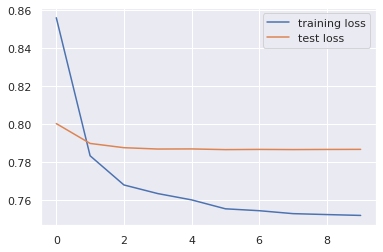

In [321]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
x = np.arange(len(training_losses))
plt.plot(x, training_losses, label = 'training loss')
plt.plot(x, test_losses, label = 'test loss')
plt.legend()

In [322]:
top50 = torch.argsort(featureExtractor.vector_weights)[0:50]
top50_words = []
for i in top50:
    top50_words.append(corpora.index_word[i])
            
top50_words

['watered',
 'worst',
 '"save',
 'disgusting.',
 '"broke',
 'horrible.',
 '"terrible',
 'hated',
 '"worst',
 'worst.',
 'awful.',
 'scam.',
 'case!',
 'poorly',
 'worse',
 'embarrassed',
 'gross.',
 'disappointment.',
 'ruined',
 'throwing',
 'dissatisfied',
 'terrible.',
 'garbage."',
 'disappointed"',
 'threw',
 'zero',
 'waste',
 'juicer',
 'salinger',
 'smut',
 'fake.',
 'sucks!"',
 'horribly.',
 'unhappy',
 'dissatisfied.',
 'whatsoever.',
 'terrible',
 'fake!',
 'ridiculous',
 'yuck.',
 'worse.',
 'weighs',
 'pretentious',
 'garbage!',
 'ridiculous!',
 'beware!',
 'trash."',
 'fake,',
 'trash.',
 'horrible!']

In [324]:
bot50 = torch.argsort(featureExtractor.vector_weights)[-50:-1]
bot50_words = []
for i in bot50:
    bot50_words.append(corpora.index_word[i])
            
bot50_words

['perfect!',
 'amazing!"',
 'gifts.',
 'biting',
 'haha',
 'diapers.',
 'shaver,',
 'great!!!',
 "annie's",
 'maldon',
 'tweezers.',
 'stamping.',
 'fabulous',
 'amazing."',
 'gorgeous!',
 'awesome!',
 '"heats',
 'daddy',
 'best!',
 'add-on',
 'trick!',
 'dermatologist,',
 'diaper',
 'amazing.',
 'sooner.',
 'subscribe',
 'tweezer',
 '"tastes',
 'disappoint.',
 'compliments',
 'pampers',
 'gallon',
 'works!!',
 'cabello',
 'curlers.',
 'amazing!',
 'norelco.',
 'works!!!',
 'diva',
 '"love',
 'cleared',
 'compliments.',
 'excelente',
 'healed',
 '"best',
 'swabs',
 'works!',
 'sucking',
 'fitbit']

In [325]:
top50 = torch.sort(featureExtractor.vector_weights)
top50

torch.return_types.sort(
values=tensor([-0.8095, -0.7767, -0.6749,  ...,  0.6942,  0.7051,  0.7353],
       device='cuda:3', grad_fn=<SortBackward0>),
indices=tensor([ 3601,  2218, 10945,  ...,  6590, 11934, 16209], device='cuda:3'))

In [326]:
featureExtractor.vector_weights[0:10]

tensor([-0.0211, -0.2614,  0.0035,  0.0702, -0.0514,  0.0104,  0.3373, -0.0008,
         0.0053, -0.0119], device='cuda:3', grad_fn=<SliceBackward0>)

In [327]:
list(corpora.word_index.keys())[0:10]

['N0O0N', '"not', '', 'once', 'touch', 'water,', 'gone!', 'light', 'on', 'to']

### Notice that the forward function we do not consider the sentence length, so all values are arround zero, because the training minimized the impact of sentence length.



# --------------------------------------------------------

# Below is a Classifier using the extracted features
1. use the same corporous
2. Draw 4 lines that classiy the sum of features into 5 possible classes



In [231]:
from torch import embedding, nn

# Draw 4 lines that classiy the sum of features into 5 possible classes
# Use device 2!

feature_4_classify = featureExtractor.vector_weights.clone().detach().cuda(3)



class LinearClassifier(nn.Module):
    
    def __init__(self):
        
        """
        :param input_dim: size of the vocabulary (number of unique tokens)
        :param output_dim: number of unique POS tags 
        :param emb_dim: embedding dimensionality of each token
        :param hid_dim: number of hidden neurons of a hidden state/cell
        :param n_layers: number of RNN layers (2 for faster training)
        :param dropout: dropout rate between 0 and 1at the embedding layer and rnn
        :param bidirectional: 1 if use bidirectional and 0 if don't
        """
        super().__init__()
        

        
        # The Initialization 
        
        lines = [[-2.0, -1.0, 0.0, 1.0, 2.0]]
        self.register_parameter(name='lines', param=torch.nn.Parameter(torch.tensor(lines, requires_grad=True)))
        #self.lines = nn.Parameter(torch.tensor(lines, requires_grad=True).cuda(3))
        
                                  

        # self.dropout = nn.Dropout(dropout)
                                  
    def forward(self, src):
        """

        :param src: a [batch_size, sentence_len] array.
                     Each row is a sequence of word indices and each column represents a position in the sequence.
        :return: the predicted logits at each position. 
        """

        z = torch.sum(featureExtractor.vector_weights[src],dim=1)
        #print(self.lines.data[0][0])
        l = torch.tensor(0.0).cuda(3)
        for i in range(len(z)):
            if i < self.lines.data[0][0]:
                z[i] = 1.0
                l += abs(self.lines.data[0][0])
            elif i < self.lines.data[0][1]:
                z[i] = 2.0
                l += abs(self.lines.data[0][1])
            elif i < self.lines.data[0][2]:
                z[i] = 3.0
                l += abs(self.lines.data[0][2])
            elif i < self.lines.data[0][3]:
                z[i] = 4.0
                l += abs(self.lines.data[0][3])
            else:
                z[i] = 5.0
                l += abs(self.lines.data[0][4])
            
        return z, l

In [254]:

# initialize the model
lc = LinearClassifier().cuda(3)
print(list(lc.parameters()))



optimizer = optim.Adam(lc.parameters())
#optimizer.add_param_group(lc.parameters())
print(optimizer.state_dict())

# we use 0 to represent padded POS tags and the loss function should ignore that.
# we calculate the sum of losses of pairs in each batch
PAD_INDEX = 0


# input: vector of [length, output_dim], integer (score)

N_EPOCHS = 1
CLIP = 1

best_test_loss = float('inf')

training_losses = []
test_losses = []

[Parameter containing:
tensor([[-2., -1.,  0.,  1.,  2.]], device='cuda:3', requires_grad=True)]
{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0]}]}


In [243]:
print(lc.parameters())

<generator object Module.parameters at 0x7fc1b2ca0d50>


In [244]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -- The Iterator is a Dataloader object. 
# -- Use for loop in iterator.batch_sampler to access each batches
# -- In this case, each batches is having length 128

# -- Need to Figure out: The way to compute loss for RNN
num_epochs_train = 0

def train(model, iterator, optimizer, clip, num_epochs=0):

    model.train()
    epoch_loss = 0
    num_batchs = 0
    total = 0
    global num_epochs_train
    random.shuffle(iterator.batch_sampler.index_batches)
    
    # batch[0]: the word batch
    # batch[1]: the tag batch (target)
    print("training ...")
    for i, batch in tqdm(enumerate(iterator.batch_sampler)):

        num_batchs += 1
        z, l = lc.forward(batch[0])
        #batch[1].cuda(3)
        # absolution distance loss
        # About 0.8 after 1st ephoch (regression loss)
        loss= (sum(abs(z.cuda(3) - batch[1].cuda(3))) +  0.5*l)/BATCH_SIZE

        # loss= torch.sqrt(sum(pow(z - torch.tensor(batch[1]).cuda(3),2)))/BATCH_SIZE

        loss.backward()
        
        # Clips gradient norm of an iterable of parameters.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        total += 1
        num_epochs_train += 1

    return epoch_loss /total


num_epochs = 0

def evaluate(model, iterator):
    
    model.eval()
    epoch_loss = 0
    total = 0
    
    global num_epochs
    for i, batch in tqdm(enumerate(iterator.batch_sampler)):
        z, l = lc.forward(batch[0].cuda(3))       
        # absolution distance loss
        loss= (sum(abs(z.cuda(3) - batch[1].cuda(3))) + 0.5*l)/BATCH_SIZE   
        epoch_loss += loss.item()
        total += 1
        
     
    num_epochs += 1
        
    return epoch_loss/total

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [245]:
for epoch in range(N_EPOCHS):  
    print("epoch start: ", epoch)  
    start_time = time.time()
    training_loss = train(lc, training_iterator, optimizer, CLIP)
    training_losses.append(training_loss)
    test_loss = evaluate(lc, test_iterator)
    test_losses.append(test_loss)  
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if test_loss < best_test_loss:
        best_test_loss = test_loss 
        torch.save(featureExtractor.state_dict(), 'best_model.pt')
        

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', end='')
    print(f'\tTrain Loss: {training_loss:.3f} | Test Loss: {test_loss:.3f}')

import pickle
with open(f'results/losses_L.pkl', 'wb') as f:
    pickle.dump({'training_losses': training_losses,
                'test_losses': test_losses}, f)

epoch start:  0
training ...


6250it [02:01, 51.52it/s]
1562it [00:15, 100.03it/s]

Epoch: 01 | Time: 2m 16s	Train Loss: 2.012 | Test Loss: 2.006


In [248]:
lc.lines

Parameter containing:
tensor([[-0.0201,  0.0136, -0.0395,  0.0689,  0.0404]], device='cuda:3',
       requires_grad=True)

In [247]:
featureExtractor.vector_weights


Parameter containing:
tensor([ 0.0091, -0.2918, -0.0111,  ...,  0.0263, -0.2554, -0.0166],
       device='cuda:3', requires_grad=True)

In [218]:
lc.forward(list(training_iterator.batch_sampler)[0][0])

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], device='cuda:3',
       grad_fn=<CopySlices>)

In [219]:
list(training_iterator.batch_sampler)[0][0]

tensor([[   20,    21,     0,  ...,  6248,   131,     0],
        [   40,  2163,   120,  ...,   110,  2512,  8327],
        [   99,    21,   131,  ...,    37,  2308,  2085],
        ...,
        [  206,   124,    30,  ...,   131,    27,  1808],
        [ 2455,  3505,   374,  ...,   419,     9,  5266],
        [   30,   283,   374,  ...,   101, 17065,  9018]])